In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [40]:
row_X = pd.read_csv('.\\articles_ko.csv', encoding='utf-8', sep=',')
row_y = pd.read_csv('.\\label_ko.csv', encoding='utf-8', sep=',')

In [41]:
row_X = row_X[row_X.target == '삼성전자']
row_y = row_y[row_y.index.isin(row_X.index)]

In [42]:
tokenizer = Okt()

In [43]:
words = {}
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.nouns(title)
    for token in tokens:
        words[token] = 1 if token not in words else words[token] + 1

In [44]:
word_to_idx = {}
for key, val in sorted(words.items(), key=lambda x: -x[1]):
    word_to_idx[key] = len(word_to_idx) + 1
    if len(word_to_idx) >= 5000:
        break

In [45]:
X = []
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.nouns(title)

    raw = []
    for token in tokens:
        num = word_to_idx[token] if token in word_to_idx else 0
        raw.append(num)
    if len(raw) < 30:
        raw += [0] * (30 - len(raw))
    X.append(raw)

In [46]:
X = np.array(X)

In [47]:
row_y.loc[row_y.updown == False, 'updown'] = 0
row_y.loc[row_y.updown == True, 'updown'] = 1
row_y.fillna(1, inplace=True)

In [48]:
y = row_y.updown
y = to_categorical(y)

In [49]:
model = Sequential([
    layers.Embedding(5001, 64),
    layers.LSTM(64, activation='tanh'),
    layers.Dense(2, activation='softmax')
])

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [51]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', metrics=['accuracy']
)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [54]:
hist = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], validation_data=(X_val, y_val))

Train on 544 samples, validate on 61 samples
Epoch 1/30
512/544 [===========================>..] - ETA: 0s - loss: 0.6802 - accuracy: 0.5703
Epoch 00001: val_accuracy improved from -inf to 0.67213, saving model to best_model.h5
544/544 [==============================] - 1s 2ms/sample - loss: 0.6791 - accuracy: 0.5735 - val_loss: 0.6417 - val_accuracy: 0.6721
Epoch 2/30
512/544 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6133
Epoch 00002: val_accuracy did not improve from 0.67213
544/544 [==============================] - 0s 246us/sample - loss: 0.6675 - accuracy: 0.6140 - val_loss: 0.6385 - val_accuracy: 0.6721
Epoch 3/30
288/544 [==============>...............] - ETA: 0s - loss: 0.6713 - accuracy: 0.6042
Epoch 00003: val_accuracy did not improve from 0.67213
544/544 [==============================] - 0s 231us/sample - loss: 0.6678 - accuracy: 0.6140 - val_loss: 0.6393 - val_accuracy: 0.6721
Epoch 4/30
256/544 [=============>................] - ETA: 0s - los

In [55]:
from tensorflow.keras.models import load_model

In [56]:
loaded_model = load_model('.\\best_model.h5')
print()
print(f'Test Accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}')


152/152 [==============================] - 0s 2ms/sample - loss: 0.6765 - accuracy: 0.5921
Test Accuracy: 0.5921


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

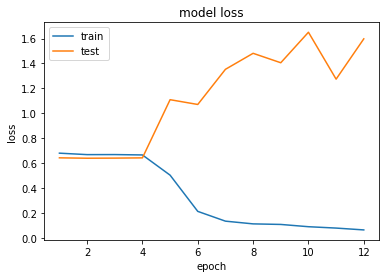

In [58]:
epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()